In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
batch_size = 64

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=test_transform
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

In [3]:
for i in range(100):
    img, label = test_data[i]
    print(i, label)

0 9
1 2
2 1
3 1
4 6
5 1
6 4
7 6
8 5
9 7
10 4
11 5
12 7
13 3
14 4
15 1
16 2
17 4
18 8
19 0
20 2
21 5
22 7
23 9
24 1
25 4
26 6
27 0
28 9
29 3
30 8
31 8
32 3
33 3
34 8
35 0
36 7
37 5
38 7
39 9
40 6
41 1
42 3
43 7
44 6
45 7
46 2
47 1
48 2
49 2
50 4
51 4
52 5
53 8
54 2
55 2
56 8
57 4
58 8
59 0
60 7
61 7
62 8
63 5
64 1
65 1
66 2
67 3
68 9
69 8
70 7
71 0
72 2
73 6
74 2
75 3
76 1
77 2
78 8
79 4
80 1
81 8
82 5
83 9
84 5
85 0
86 3
87 2
88 0
89 6
90 5
91 3
92 6
93 7
94 1
95 8
96 0
97 1
98 4
99 2


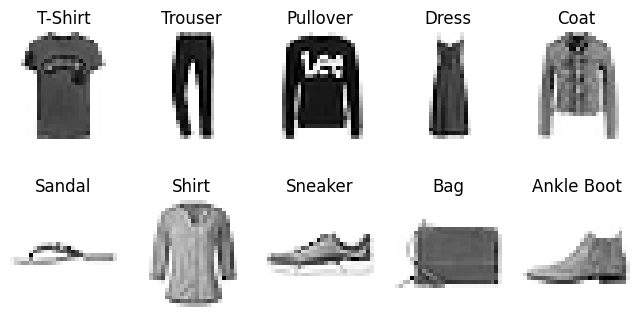

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

example_index = [19, 2, 1, 13, 10, 8, 4, 9, 18, 0]
figure = plt.figure(figsize=(8, 4))
for i in range(10):
    img, label = test_data[example_index[i]]
    figure.add_subplot(2, 5, i+1)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="Grays")
plt.show()

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.Conv2d(6, 16, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*4*4, 120),
            nn.ReLU(),
            nn.BatchNorm1d(120),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.BatchNorm1d(84),
            nn.Linear(84, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [6]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*7*7, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [7]:
class NetworkTrainer:
    def __init__(
            self, model: nn.Module, 
            loss_fn: nn.modules.loss._Loss, 
            optimiser: optim.Optimizer,
            scheduler: optim.lr_scheduler._LRScheduler = None
        ):
        self.model = model
        self.loss_fn = loss_fn
        self.optimiser = optimiser
        self.scheduler = scheduler

    def train_model(self, epochs):
        train_loss_list = []
        train_acc_list = []
        test_loss_list = []
        test_acc_list = []
        for epoch in range(epochs):
            print(f'EPOCH {epoch+1}')
            train_loss, train_acc = self._train_epoch()
            test_loss, test_acc = self._eval_epoch()
            if self.scheduler is not None:
                self.scheduler.step()
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            print(f'Loss: {train_loss:.3f}, Val_Loss: {test_loss:.3f}')
            print(f'Accuracy: {train_acc:.2f}, Val_Accuracy: {test_acc:.2f}\n')
        return train_loss_list, train_acc_list, test_loss_list, test_acc_list

    def _train_epoch(self):
        self.model.train(True)
        running_loss = 0.0
        correct = 0
        for i, data in enumerate(train_dataloader):
            inputs: torch.Tensor = data[0]
            labels = data[1]
            self.optimiser.zero_grad()
            outputs = self.model(inputs)
            loss: torch.Tensor = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimiser.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
        avg_loss = running_loss / len(train_data)
        accuracy = 100 * correct / len(train_data)
        return avg_loss, accuracy

    def _eval_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                inputs: torch.Tensor = data[0]
                labels = data[1]
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, labels)
                running_loss += loss * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels)
        avg_loss = running_loss / len(test_data)
        accuracy = 100 * correct / len(test_data)
        return avg_loss, accuracy

In [8]:
def plot_results(results):
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = results

    epochs = len(train_loss_list)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
    ax1.plot(range(1,epochs+1), train_loss_list, label='Train')
    ax1.plot(range(1,epochs+1), test_loss_list, label='Test')
    ax1.set_xticks(range(5,epochs+1,5))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(range(1,epochs+1), train_acc_list, label='Train')
    ax2.plot(range(1,epochs+1), test_acc_list, label='Test')
    ax2.set_xticks(range(5,epochs+1,5))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [10]:
model = VGG().to(device)
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimiser, 20)

EPOCH 1
Loss: 1.655, Val_Loss: 1.613
Accuracy: 80.81, Val_Accuracy: 84.95

EPOCH 2
Loss: 1.609, Val_Loss: 1.608
Accuracy: 85.30, Val_Accuracy: 85.22

EPOCH 3
Loss: 1.592, Val_Loss: 1.581
Accuracy: 86.96, Val_Accuracy: 87.91

EPOCH 4
Loss: 1.583, Val_Loss: 1.576
Accuracy: 87.88, Val_Accuracy: 88.47

EPOCH 5
Loss: 1.577, Val_Loss: 1.570
Accuracy: 88.48, Val_Accuracy: 89.13

EPOCH 6
Loss: 1.573, Val_Loss: 1.591
Accuracy: 88.90, Val_Accuracy: 87.18

EPOCH 7
Loss: 1.571, Val_Loss: 1.572
Accuracy: 89.06, Val_Accuracy: 89.00

EPOCH 8
Loss: 1.569, Val_Loss: 1.575
Accuracy: 89.29, Val_Accuracy: 88.50

EPOCH 9
Loss: 1.567, Val_Loss: 1.562
Accuracy: 89.51, Val_Accuracy: 90.06

EPOCH 10
Loss: 1.567, Val_Loss: 1.589
Accuracy: 89.54, Val_Accuracy: 87.21

EPOCH 11
Loss: 1.566, Val_Loss: 1.568
Accuracy: 89.55, Val_Accuracy: 89.22

EPOCH 12
Loss: 1.565, Val_Loss: 1.566
Accuracy: 89.69, Val_Accuracy: 89.56

EPOCH 13
Loss: 1.565, Val_Loss: 1.564
Accuracy: 89.75, Val_Accuracy: 89.76

EPOCH 14
Loss: 1.563,

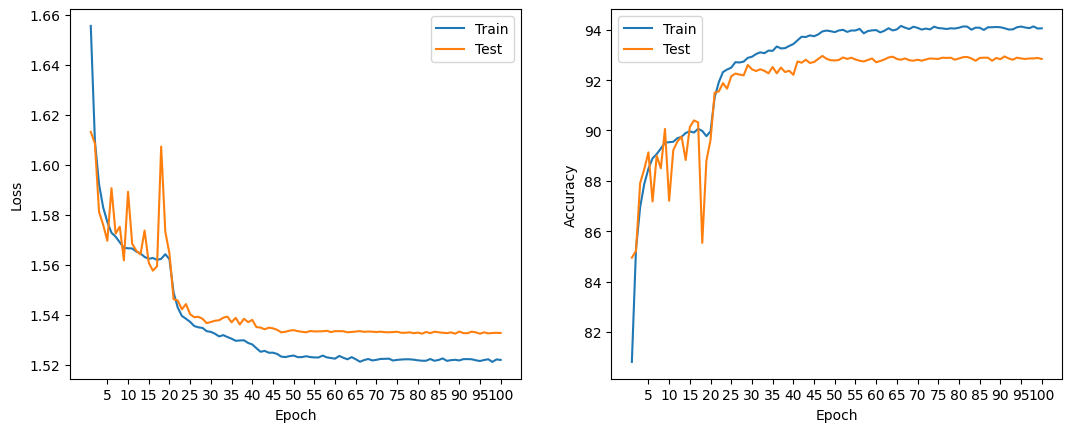

In [11]:
trainer = NetworkTrainer(model, loss_fn, optimiser, scheduler)
results = trainer.train_model(100)
plot_results(results)

In [12]:
model.eval()
y_test = []
y_pred = []
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        inputs: torch.Tensor = data[0]
        labels = data[1]
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_test.extend(labels)
        y_pred.extend(preds)

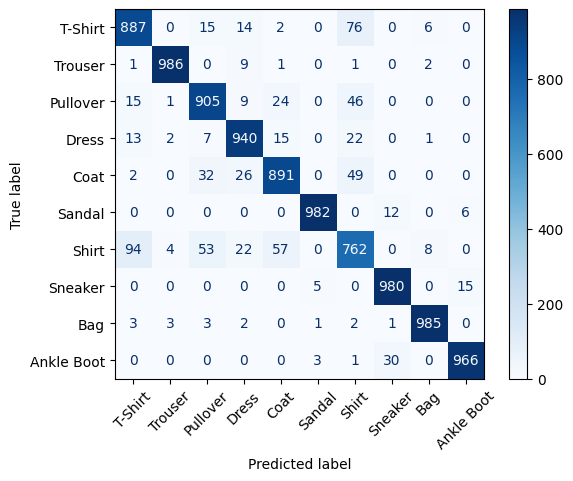

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
x_locs, _ = plt.xticks()
y_locs, _ = plt.yticks()
plt.xticks(x_locs, labels_map.values(), rotation=45)
plt.yticks(y_locs, labels_map.values())
plt.show()